In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import pickle

In [2]:
data=pd.read_csv("trimmed_data_v3.csv",index_col=0)

# 扔掉nan
data=data[~np.isnan(data.vol)]
data.head()

,Date,sec_id,fut_ret,vol,X1,X3,X4,X6,X7,X1_norm,X3_norm,X4_norm,X6_norm,X7_norm,log_vol
0,0.0,0.000000,0.037521,0.000563,0.002766,0.000000,0.0,0.0,0.000000e+00,2.128681,0.095161,-0.109858,0.180895,-0.080587,0.269877
1,0.0,0.000502,0.005565,0.000805,-0.000461,0.000000,0.0,0.0,0.000000e+00,-0.674305,0.095161,-0.109858,0.180895,-0.080587,0.879423
2,0.0,0.001005,-0.008732,0.000584,0.001580,-0.000464,0.0,0.0,3.921761e-13,1.098681,-5.279814,-0.109858,0.180895,-0.080587,0.331473
3,0.0,0.001507,0.000695,0.000326,0.000243,0.000000,0.0,0.0,0.000000e+00,-0.062127,0.095161,-0.109858,0.180895,-0.080587,-0.598987
4,0.0,0.002009,-0.002755,0.000461,0.000259,0.000000,0.0,0.0,0.000000e+00,-0.048683,0.095161,-0.109858,0.180895,-0.080587,-0.057603


In [3]:
print(len(data))

371652


In [4]:
data.iloc[277938]

Date       0.758794
sec_id     0.000000
fut_ret    0.007288
vol        0.000514
X1        -0.000410
X3         0.000000
X4         0.000000
X6        -0.000073
X7         0.000000
X1_norm   -0.629850
X3_norm    0.095161
X4_norm   -0.109858
X6_norm   -0.180296
X7_norm   -0.080587
log_vol    0.118069
Name: 300792, dtype: float64

In [5]:
data.iloc[277937]

Date       0.753769
sec_id     0.993973
fut_ret    0.002754
vol        0.000838
X1        -0.000026
X3         0.000000
X4         0.000000
X6         0.000000
X7         0.000000
X1_norm   -0.296064
X3_norm    0.095161
X4_norm   -0.109858
X6_norm    0.180895
X7_norm   -0.080587
log_vol    0.949744
Name: 300779, dtype: float64

In [6]:
data_train=data.iloc[:277938]
data_test=data.iloc[277938:]

In [7]:
print(len(data_train))
print(len(data_test))

277938
93714


In [8]:
fut_ret=data["fut_ret"]
features=data.drop(columns=["fut_ret","Date","X1_norm","X3_norm","X4_norm","X6_norm","X7_norm","log_vol"])
features.head()

,sec_id,vol,X1,X3,X4,X6,X7
0,0.000000,0.000563,0.002766,0.000000,0.0,0.0,0.000000e+00
1,0.000502,0.000805,-0.000461,0.000000,0.0,0.0,0.000000e+00
2,0.001005,0.000584,0.001580,-0.000464,0.0,0.0,3.921761e-13
3,0.001507,0.000326,0.000243,0.000000,0.0,0.0,0.000000e+00
4,0.002009,0.000461,0.000259,0.000000,0.0,0.0,0.000000e+00


In [9]:
y_train=fut_ret[:277938]
y_test=fut_ret[277938:]
X_train=features[:277938]
X_test=features[277938:]

In [10]:
import random

class TreeNode:
    def predict(x, y):
        assert False

    def depth(self):
        assert False

class BranchNode(TreeNode):
    def __init__(self, left, right,split_var_index, split_var_value):
        self.left = left
        self.right = right
        self.split_var_index = split_var_index
        self.split_var_value = split_var_value

    def predict(self, x):
        
        svar = x[:, self.split_var_index]
        
        if self.split_var_value==0:
            is_left=svar == 0 
        else:
            is_left = svar < self.split_var_value
        leftx = x[is_left]
        rightx = x[~is_left]

        rv = np.zeros(x.shape[0])
        rv[is_left] = self.left.predict(leftx)
        rv[~is_left] = self.right.predict(rightx)

        return rv

    def depth(self):
        return 1 + max(self.left.depth(), self.right.depth())

class LeafNode(TreeNode):
    def __init__(self, mu):
        self.mu = mu

    def predict(self, x):
        return np.repeat(self.mu, x.shape[0])

    def depth(self):
        return 1

class RegressionTree:
    def __init__(self, max_depth, min_points_in_leaf,method):
        self.max_depth = max_depth
        self.min_points_in_leaf = min_points_in_leaf
        self.method=method

    def predict(self, x):
        assert self.fitted
        return self.root.predict(x)

    def fit(self, x, y):
        self.fitted = True
        self.root = self.fit_internal(x, y, 1)
        
    
    def fit_internal(self, x, y, current_depth):
        # implement this
        num_features = x.shape[1]
        num_rows = x.shape[0]
        var_orig = np.var(y)

        if current_depth == self.max_depth:
            return LeafNode(np.mean(y))

        best_variable = None
        

        vr_max=0
        if self.method==1:
            which=[i for i in range(num_features)]
        else:# select1/3 of features
            which=random.sample([i for i in range(num_features)], 3)
        # Here, we have to loop over all features and figure out which one
        # might be splittable, and if it is, how to split it to maximize Variance Reduction
        for i in which:
            # a lot of code goes here
            '''
            x_temp = sorted(x[:,i])
            x_split_points = self.split_p[i]
            
            
            for split_point in x_split_points:
                is_left = x[:,i] < split_point
                y_left = y[is_left]
                y_right = y[~is_left]
                if (len(y_left) < self.min_points_in_leaf) or (len(y_right) < self.min_points_in_leaf):
                    continue
                vr_temp = var_orig - len(y_left)/num_rows* np.var(y_left)- len(y_right)/num_rows*np.var(y_right)
                
                if vr_temp > vr_max:
                    vr_max = vr_temp
                    
                    # get the best attribute index and split point
                    best_variable = [i, split_point]

        if best_variable is None:
            return LeafNode(np.mean(y))
        '''
            
            #print(type(x))
            is_left=(x[:,i]==0.0)
            y_left=y[is_left]
            if len(y_left)>self.min_points_in_leaf:
                y_left=y[is_left]
                y_right = y[~is_left]
                if (len(y_left) < self.min_points_in_leaf) or (len(y_right) < self.min_points_in_leaf):
                        continue

                vr_temp = var_orig - len(y_left)/num_rows* np.var(y_left)- len(y_right)/num_rows*np.var(y_right)
                if vr_temp > vr_max:
                        vr_max = vr_temp

                        best_variable = [i, 0]
            
            else:
                
                x_split_points=random.sample(list(x[:,i]), 5)
               
                for split_point in x_split_points:
                    is_left = x[:,i] < split_point
                    y_left = y[is_left]
                    y_right = y[~is_left]
                    if (len(y_left) < self.min_points_in_leaf) or (len(y_right) < self.min_points_in_leaf):
                        continue
                    vr_temp = var_orig - len(y_left)/num_rows* np.var(y_left)- len(y_right)/num_rows*np.var(y_right)

                    if vr_temp > vr_max:
                        vr_max = vr_temp

                        # get the best attribute index and split point
                        best_variable = [i, split_point]
            
        if best_variable is None:
            return LeafNode(np.mean(y))
            
        else:
            #return BranchNode(....) FILL THIS IN
            
            if best_variable[1]==0:
                is_left=(x[:,best_variable[0]] == 0.0)
            
            else: 
                is_left = x[:,best_variable[0]] < best_variable[1]
            
            # get the left part and right part for x and y
            x_left_node = x[is_left]
            y_left_node = y[is_left]
            x_right_node = x[~is_left]
            y_right_node = y[~is_left]
            
            
            # recursion
            return BranchNode(self.fit_internal(x[is_left], y[is_left], current_depth+1),
                              self.fit_internal(x[~is_left], y[~is_left], current_depth+1),
                              best_variable[0],
                              best_variable[1]) 


    def depth(self):
        return self.root.depth()

In [11]:
def bootstrap(x,y,n):
    x_bootstrap=[]
    y_bootstrap=[]
    for i in range(n):
        temp=np.random.randint(0,n)
        x_bootstrap.append(x[temp,:])
        y_bootstrap.append(y[temp])
    return np.array(x_bootstrap),np.array(y_bootstrap)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
0.0013113296411830788


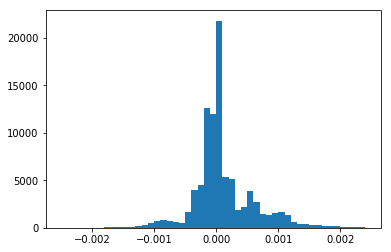

In [12]:
#my_forest contains all the trees in the model, and use my_forest[i].predict() to predict the ith tree's result
#predictions contains all the predict from test set
#the average out-sample r^2 is 13 bps

my_forest=[]
for i in range(180):
    print(i)
    new_X,new_Y=bootstrap(X_train.values,y_train.values,len(y_train))
    regression_tree = RegressionTree(7,500,1)
    regression_tree.fit(new_X,new_Y)
    my_forest.append(regression_tree)

predictions=[]
for i in range(0,len(my_forest)):
    y_test_hat = my_forest[i].predict(X_test.values)
    predictions.append(y_test_hat)
result=np.mean(predictions,0)
plt.hist(result,bins=np.arange(-0.0025, 0.0025, 0.0001))
print(r2_score(y_test,result))
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
0.001336697887645677


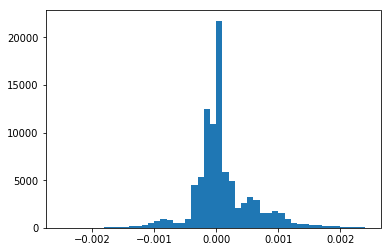

In [13]:
#this model is almost the same as before, the only change is the min_point_leaf is 100, which is the same as Hugo's pamameter
#I test those two models and they both give me almost the same result
#the average out-sample r^2 is 13 bps


my_forest2=[]
for i in range(180):
    print(i)
    new_X,new_Y=bootstrap(X_train.values,y_train.values,len(y_train))
    regression_tree = RegressionTree(7,100,1)
    regression_tree.fit(new_X,new_Y)
    my_forest2.append(regression_tree)

predictions2=[]
for i in range(0,len(my_forest2)):
    y_test_hat = my_forest2[i].predict(X_test.values)
    predictions2.append(y_test_hat)
result2=np.mean(predictions2,0)
plt.hist(result2,bins=np.arange(-0.0025, 0.0025, 0.0001))
print(r2_score(y_test,result2))
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
0.001056001282604746


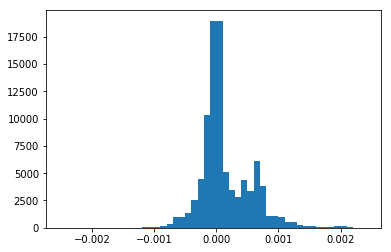

In [14]:
#this model is a little bit different, which is I random choose 1/3 features to split on each node. So this forest has lower correlation
#but this one gives me a worse result, the only advantage is that training is faster than before.
#the average out sample r^2 is about 11 bps


my_forest3=[]
for i in range(180):
    print(i)
    new_X,new_Y=bootstrap(X_train.values,y_train.values,len(y_train))
    regression_tree = RegressionTree(7,100,0)
    regression_tree.fit(new_X,new_Y)
    my_forest3.append(regression_tree)

predictions3=[]
for i in range(0,len(my_forest3)):
    y_test_hat = my_forest3[i].predict(X_test.values)
    predictions3.append(y_test_hat)
result3=np.mean(predictions3,0)
plt.hist(result3,bins=np.arange(-0.0025, 0.0025, 0.0001))
print(r2_score(y_test,result3))
plt.show()